In [1]:
library('purrr')
library('tidyverse')

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


Consider this example from [Think Stats 2e](https://greenteapress.com/wp/think-stats-2e/): 

You operate a casino and a player at one of your craps tables is winning. You suspect the player has employed
a crooked die. You collect the following data for the players first 60 rolls with the die in question.

In [ ]:
observed_data = tribble(
    ~die_roll, ~count,
     1,          8,
     2,          9,
     3,         19,
     4,          5,
     5,          8,
     6,          11
)

observed_data

die_roll,count
<dbl>,<dbl>
1,8
2,9
3,19
4,5
5,8
6,11


Let's select a "test statistic" quantify how the observed data deviates from what we would expect *on average* from a fair die. Then we can find the null distribution of the test statistic and leverage that distribution to investigate the fairness of the suspicious die.

The following is a table that represents a fair die:

In [12]:
fair_die = tribble(
    ~die_roll,
    1,
    2,
    3,
    4,
    5, 
    6
)

fair_die

die_roll
<dbl>
1
2
3
4
5
6


We can use the `slice_sample` with `replace = TRUE` to simulate a "n" dice rolls.

In [4]:
slice_sample(fair_die, n = 10, replace = TRUE)

die_roll
<dbl>
3
4
1
4
1
3
4
5
2


The following is a function that calcuates the absolute deviance for a set of "n" rolls from what we would expect from a fair dice *on average*.

```r
abs_deviance = function(roll_frequencies) {
    n = sum(roll_frequencies)
    expected = n / 6
    abs(roll_frequencies - expected) |> sum()
}

```

Create this function in the cell below and calculate "absolute deviance" for the suspicious die.

(**Hint:** use `summarize(abs_dev = abs_deviance(count))`)

In [7]:
abs_deviance = function(roll_frequencies) {
    n = sum(roll_frequencies)
    expected = n / 6
    abs(roll_frequencies - expected) |> sum()
}

In [9]:
observed_data |> summarize(abs_dev = abs_deviance(count))

abs_dev
<dbl>
20


The `purrr` code below generates simulates rolling a fair die 60 times for 1,000 iterations.

```r
n_iterations = 1000
n_rolls = 60

1:n_iterations |> map_dfr(~slice_sample(fair_die, n = 60, replace = TRUE), .id = 'replicate')

```

Run this code and collect the output in a table called `simulated_data`.

In [14]:
n_iterations <- 1000
n_rolls <- 60

simulated_data <- 1:n_iterations |> map_dfr(~slice_sample(fair_die, n = n_rolls, replace = TRUE), .id = 'replicate')

simulated_data |> head()
simulated_data |> tail()

replicate,die_roll
<chr>,<dbl>
1,3
1,2
1,3
1,5
1,6
1,4


replicate,die_roll
<chr>,<dbl>
1000,6
1000,4
1000,6
1000,6
1000,3
1000,6


Now we are ready to calculate the null distribution of our test statistic!

Using `simulated_data`,
1. `group_by` the `replicate` variable (add `.drop = FALSE` to make sure you include zero frequency counts),
2. `count` the frequency of `die_roll`. Last, 
3. `summarize` each group using the `abs_deviance` function from above. Call you new column `abs_dev`.

Capture the output into a table called `abs_dev_null_dist`.

In [19]:
abs_dev_null_dist <- simulated_data |> group_by(replicate, .drop = FALSE) |> 
  count(die_roll) |>
  summarize(abs_dev = abs_deviance(n))

abs_dev_null_dist |> head()
abs_dev_null_dist |> tail()

replicate,abs_dev
<chr>,<dbl>
1,14
10,10
100,16
1000,10
101,14
102,18


replicate,abs_dev
<chr>,<dbl>
994,14
995,8
996,12
997,20
998,12
999,10


Plot a histogram of `abs_dev`. Use `geom_vline` to show the positon of our the test statistic calculated from the suspicious die.

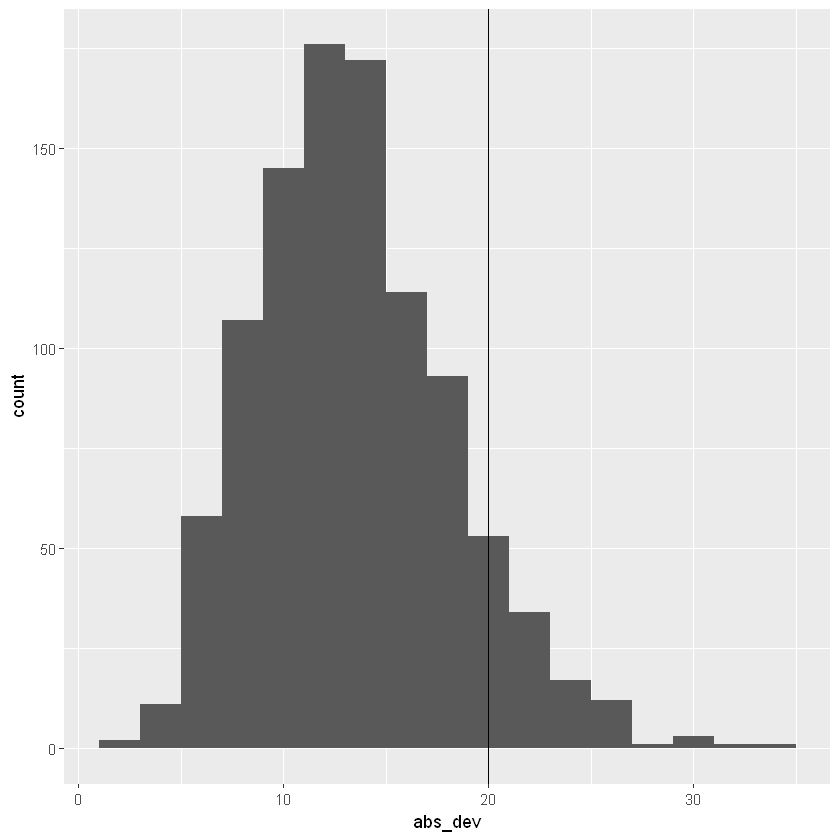

In [24]:
abs_dev_null_dist |> ggplot(aes(x = abs_dev)) +
  geom_histogram(binwidth = 2) +
  geom_vline(xintercept = 20)

Can you calculate a "p-value" for our suspicous die using the null distribution and the observed test statistic?

In [27]:
abs_dev_null_dist |> mutate(extreme = abs_dev >= 20) |> summarize(p_value = sum(extreme) / n())

p_value
<dbl>
0.122


Redo the steps above but this time use the [Chi square](https://en.wikipedia.org/wiki/Chi-squared_test) statistic. The **Chi square** test statistic simply quantifies the sum of squared differences from expected values divided by the expected value.

You can re-use `simulated_data`.

Here is a function in `R`:

```r
chi_square = function(roll_frequencies) {
    n = sum(roll_frequencies)
    expected = n / 6
    sum((roll_frequencies - expected)**2 / expected)
}

```

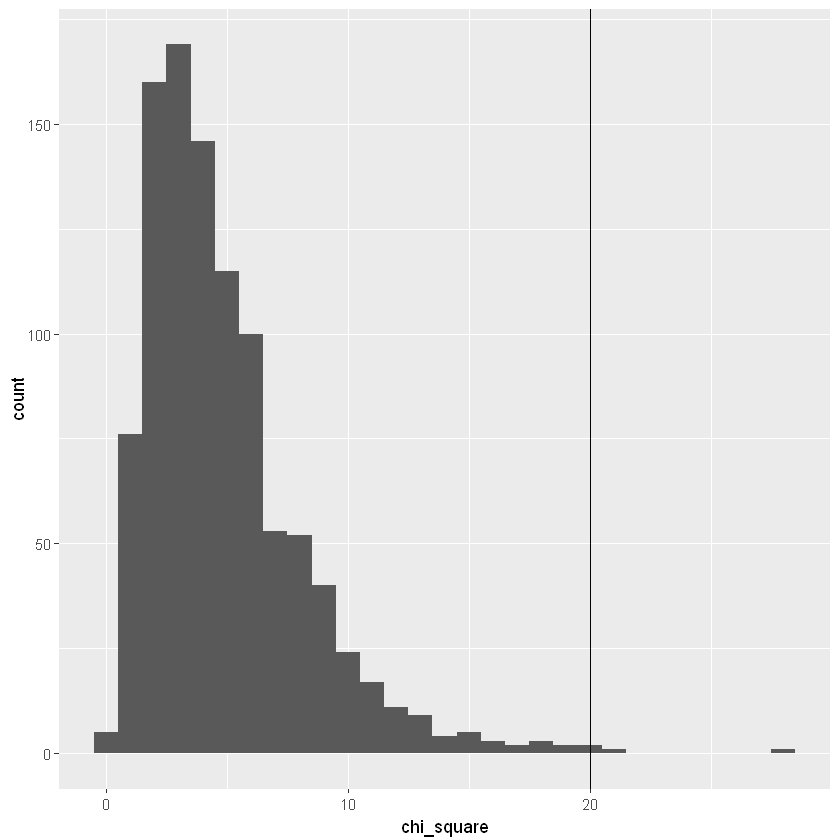

In [30]:
chi_square = function(roll_frequencies) {
    n = sum(roll_frequencies)
    expected = n / 6
    sum((roll_frequencies - expected)**2 / expected)
}
chi_square_null_dist = simulated_data |>
  group_by(replicate, .drop = FALSE) |>
  count(die_roll) |>
  summarize(chi_square = chi_square(n))

ggplot(chi_square_null_dist, aes(x = chi_square)) +
  geom_histogram(binwidth = 1) +
  geom_vline(xintercept = 20)

In [32]:
chi_square_null_dist |> head()
chi_square_null_dist |> tail()

replicate,chi_square
<chr>,<dbl>
1,3.8
10,3.6
100,6.6
1000,1.8
101,5.4
102,7.0


replicate,chi_square
<chr>,<dbl>
994,5.4
995,1.4
996,2.8
997,13.2
998,3.4
999,2.0


Is the "p-value" using the Chi square test statistic lower or higher than that calcuated using "absolute deviance" as the test statistic? 

In [ ]:
chi_square_null_dist |> mutate(extreme = chi_square >= 20) |> summarize(p_value = sum(extreme) / n())

p_value
<dbl>
0.003


: 

# p-value <br />
Chi Square vs. Absolute Deviance<br />
0.003 vs. 0.122